# Optimization and Topological Data Analysis

Mathieu Carrière, https://mathieucarriere.github.io/website/

In this notebook, we are going to see how to combine Gudhi and Tensorflow in order to do persistence optimization!

In [1]:
import numpy                 as np
import tensorflow            as tf
import matplotlib.pyplot     as plt
import pandas                as pd
import gudhi                 as gd
from gudhi.tensorflow        import LowerStarSimplexTreeLayer, CubicalLayer, RipsLayer

# Point cloud

You might have already seen a few examples of persistence diagram computations on point clouds. Among the different possibilities, the Rips filtration is the most common option due to its simplicity and easy implementation. In this section, we will see how Gudhi and Tensorflow can be combined to perform optimization of Vietoris-Rips persistence diagrams.

Let's have a quick refresher ;-)

First, let's generate a random point cloud in the unit square and visualize it.

In this section, we implement the point cloud experiment, where we optimize loops in a point cloud using 1-dimensional homology.

In [2]:
np.random.seed(1)
Xinit = np.array(np.random.uniform(high=1., low=-1., size=(300,2)), dtype=np.float32)

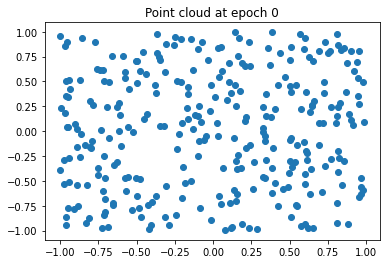

In [3]:
plt.figure()
plt.scatter(Xinit[:,0], Xinit[:,1])
plt.title('Point cloud at epoch 0')
plt.show()

Yep, looks pretty random indeed. Let's now compute its Rips persistence diagram. This is literally two lines of code with Gudhi :-)

In [4]:
st = gd.RipsComplex(points=Xinit, max_edge_length=1.).create_simplex_tree(max_dimension=2)
dgm = st.persistence()

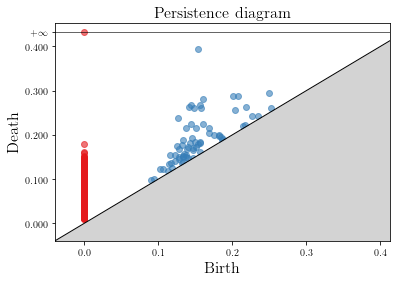

In [5]:
plot = gd.plot_persistence_diagram(dgm)

As usual, there is one point (in dimension 0) at $+\infty$ which represents the whole connected component, a bunch of points in dimension 0 with abscissa 0 (actually, as many as there are points in the initial point cloud), and some points in dimension 1. There is nothing else because we only kept the 2-skeleton of the Rips complex in the previous cell.

This is great. But have you ever thought about the inverse problem? That is, can you tweak the point cloud so that the corresponding persistence diagram satisfies some properties? That sounds hard. Turns out it is not if you combine Gudhi and Tensorflow ;-)

Before jumping to the code, let's think about what's happening here. If you think about how persistence is computed, the coordinates of any point $p$ in a persistence diagram are actually given by the filtration values of two very specific simplices: the so-called positive and negative simplices of $p$, denoted by $\sigma_+(p)$ and $\sigma_-(p)$ (check chapter VII.1 in [this reference book](https://books.google.com/books/about/Computational_Topology.html?id=MDXa6gFRZuIC) for more details if you feel lost). So, we have: $$p=(f(\sigma_+(p)), f(\sigma_-(p))),$$
where $f$ is the filtration function. This means that if $f$ is actually defined by some parameters $f = f_\theta$, then the gradient $\nabla_\theta p$ is actually given by $\nabla_\theta f_\theta(\sigma_+(p))$ and $\nabla_\theta f_\theta(\sigma_-(p))$.

Interesting, but how does this look like for the Rips filtration? Well, first, the parameters $\theta$ are now the positions of the points in the point cloud. Second, as you may recall, the filtration value of any simplex is simply the maximal distance between any two vertices in the simplex: $f(\{v_0,\cdots, v_n\})=\|v_a-v_b\|$, $0\leq a,b\leq n$, where $\|v_a-v_b\|\geq \|v_i-v_j\|$, $\forall 0\leq i,j \leq n$. This has two consequences. First, this means that one can create the persistence diagram by simply picking entries of the distance matrix between the points. Second, this also means that the gradient of $f$ only depends on the positions of $v_a$ and $v_b$: $\nabla f=\frac{v_a-v_b}{\|v_a-v_b\|}$. You can check [this article](http://proceedings.mlr.press/v139/carriere21a/carriere21a.pdf) for more details.

All right! So the only thing that remains to do is to compute the positive and negative simplices, right? Turns out that Gudhi can do that with the TensorFlow layer called `RipsLayer`!

In [6]:
X = tf.Variable(initial_value=Xinit, trainable=True)
layer = RipsLayer(maximum_edge_length=1., dimension=1)

Next, we define a learning rate and an optimizer.

In [7]:
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-1, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.)

Finally, we can launch the optimization! Our loss is the opposite of the sum of squares of the distances to the diagonal of the points in the diagram (plus a regularization term that forces the points to stay in the unit square). This will force the persistence diagram to have many prominent points, and thus the point cloud will contain as much loops as possible. Let's train!

In [8]:
losses, dgms = [], []
for epoch in range(1000+1):
    with tf.GradientTape() as tape:
        dgm = layer.call(X)
        loss = -tf.math.reduce_sum(tf.square(.5*(dgm[:,1]-dgm[:,0]))) + tf.reduce_sum(tf.maximum(tf.abs(X)-1, 0))
    gradients = tape.gradient(loss, [X])
    
    # We also apply a small random noise to the gradient to ensure convergence 
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [X]))
    losses.append(loss.numpy())
    dgms.append(dgm)

Let's have a look at the results.

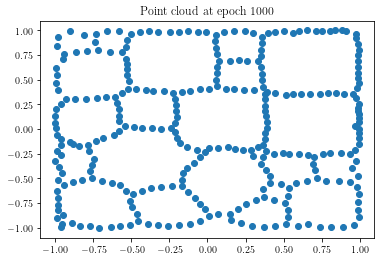

In [9]:
plt.figure()
plt.scatter(X.numpy()[:,0], X.numpy()[:,1])
plt.title('Point cloud at epoch ' + str(epoch))
plt.show()

Looks like there are more cycles indeed ;-)

Let's also visualize the loss and the sequence of iterates.

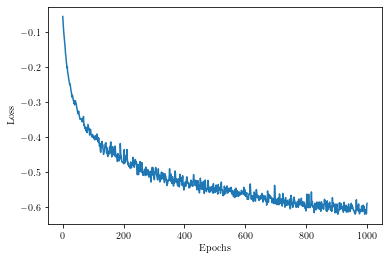

In [10]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

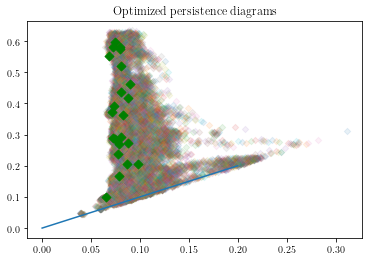

In [11]:
plt.figure()
for dg in dgms[:5:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='green')
plt.plot([-0.,.2], [-0.,.2])
plt.title('Optimized persistence diagrams')
plt.show()

# Image

We can actually play the same game with images! Indeed, Gudhi contains code for computing [cubical persistence](http://www2.im.uj.edu.pl/mpd/publications/Wagner_persistence.pdf), which is very well-suited for handling images. For instance, it can be used to filter a 2D image with its pixel values. Overall, the optimization follows the exact same steps as before, except that we use pixel filtration instead of Rips filtration. This means that the parameters $\theta$ that we are now going to optimize are the pixel values themselves, and that the gradients for positive simplex $\nabla_\theta f_\theta(\sigma_+(p))$ and negative simplex $\nabla_\theta f_\theta(\sigma_-(p))$ now simply equal $1$ for the pixels associated to $\sigma_+(p)$ and $\sigma_-(p)$ and $0$ for all other pixels. All of that is implemented in `CubicalLayer`.

We are going to use the following image:

In [12]:
I = np.array(pd.read_csv('datasets/mnist_test.csv', header=None, sep=','), dtype=np.float32)
idx = np.argwhere(I[:,0] == 8)
image = np.reshape(-I[idx[8],1:], [28,28])
image = (image-image.min())/(image.max()-image.min())
image_clean = np.array(image)
image[2:5,2:5]        -= 0.6
image[25:27,25:27]    -= 0.6
image[25:27,2:5]      -= 0.6
image[1:4,24:26]      -= 0.6

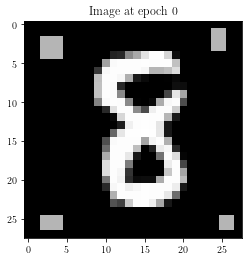

In [13]:
plt.figure()
plt.imshow(image, cmap='Greys')
plt.title('Image at epoch 0')
plt.show()

As you can see, the image contains four stains. Since those stains correspond to connected components, we can detect them with 0-dimensional persistent homology, and try to remove them by optimizing the pixel values so that the points in the 0-dimensional persistence diagram have minimal persistence. Also, as in the previous section,
we add a regularization term that forces the pixel values to be either 0 or 1.

In [14]:
X = tf.Variable(initial_value=np.array(image, dtype=np.float32), trainable=True)
layer = CubicalLayer(dimension=0)

In [15]:
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-3, decay_steps=10, decay_rate=.01)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

In [16]:
losses, dgms = [], []
for epoch in range(3000+1):
    with tf.GradientTape() as tape:
        dgm = layer.call(X)
        loss = 10*tf.math.reduce_sum(tf.abs(dgm[:,1]-dgm[:,0])) \
                 + tf.math.reduce_sum(tf.math.minimum(tf.abs(X),tf.abs(1-X)))
    gradients = tape.gradient(loss, [X])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [X]))
    losses.append(loss.numpy())
    dgms.append(dgm)

Let's visualize the result!

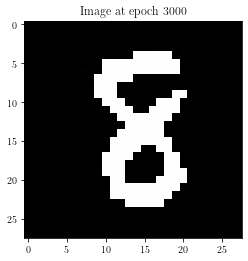

In [17]:
plt.figure()
plt.imshow(X.numpy(), cmap='Greys')
plt.title('Image at epoch ' + str(epoch))
plt.show()

Yay! The stains have been removed!

As always, let's check convergence and have a look at the iterates.

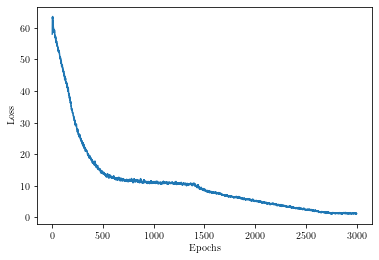

In [18]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

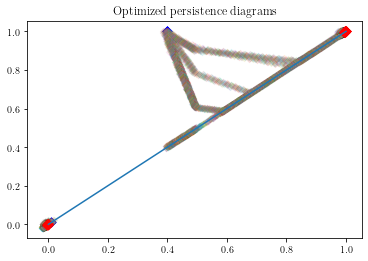

In [19]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=0.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([0,1], [0,1])
plt.title('Optimized persistence diagrams')
plt.show()

# Regression

Finally, Gudhi can also optimize the persistence diagram of a simplicial complex filtered by the lower-star filtration induced by its vertices. Pretty much like for images, the parameters $\theta$ that we are now going to optimize are the vertex values themselves, and the gradients associated to the point $p=(f_\theta(\sigma_+(p)), f_\theta(\sigma_-(p)))$ is simply 1 on all vertices that are part of $\sigma_+(p)$ and $\sigma_-(p)$ and $0$ for all other vertices. All of that is implemented in `LowerStarSimplexTreeLayer`.

We are going to illustrate this on a regression task $Y=X\cdot\beta^*+\epsilon$, where $X\in {\mathbb R}^{n\times p}$, $Y\in {\mathbb R}^{n}$, $\beta^*\in {\mathbb R}^{p}$ and $\epsilon$ is a small random noise. Moreover, the unknown coefficients $\beta^*$ have a specific shape, that we assume is known as a prior. 

In [20]:
np.random.seed(0)
n, p = 50, 100
betastar = np.concatenate([np.linspace(-1.,1.,33) for _ in range(3)] + [[-1.]])

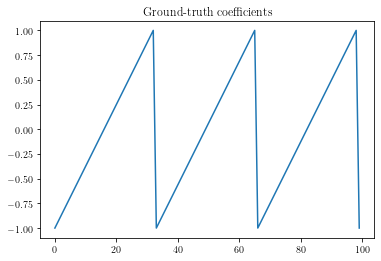

In [21]:
plt.figure()
plt.plot(betastar)
plt.title('Ground-truth coefficients')
plt.show()

Indeed, when we plot the coefficients, the line they form has three peaks, that can be detected with 0-dimensional persistent homology. Our task will be to find $\beta^*$, knowing that its 0-dimensional persistence diagram should have three points.

Let's first generate the data.

In [22]:
X = np.array(np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n), dtype=np.float32)
Y = np.array(np.matmul(X, betastar) + .05 * np.random.randn(n), dtype=np.float32)

We also store the line formed by the coefficients in a simplex tree.

In [23]:
stbase = gd.SimplexTree()
for i in range(p-1):
    stbase.insert([i,i+1], -1e10)

Here's our initial (random) guess for $\beta^*$.

In [24]:
betainit = np.random.uniform(low=-1., high=1., size=[p])
betainit[np.array([25,60,99])] = np.array([-1,-1,-1])

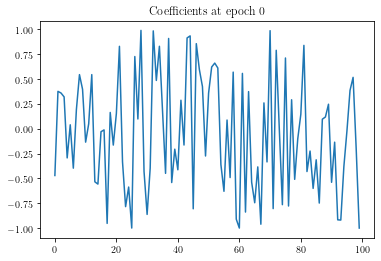

In [25]:
plt.figure()
plt.plot(betainit)
plt.title('Coefficients at epoch 0')
plt.show()

For the sake of comparison, we will optimize the coefficients with different losses: using no regularization, using total variation, and using total variation and 0-dimensional persistent homology (i.e., forcing the 0-dimensional persistence diagram to have only three points).

Let's first optimize the initial coefficients without any penalty.

In [26]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses, betas = [], []
for epoch in range(100+1):
    with tf.GradientTape() as tape:
        loss = 2 * tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y))
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)    

    optimizer.apply_gradients(zip(gradients, [beta]))
    losses.append(loss.numpy())
    betas.append(beta.numpy()[:,0])
    
beta_std = -betas[-1]

Now, let's try with total variation.

In [27]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses, betas = [], []
for epoch in range(100+1):
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + 1e3 * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)

    optimizer.apply_gradients(zip(gradients, [beta]))
    losses.append(loss.numpy())
    betas.append(beta.numpy()[:,0])
                 
beta_stdtot = -betas[-1]

Finally, let's also add a topological regularization with `LowerStarSimplexTreeLayer`.

In [28]:
beta = tf.Variable(initial_value=np.array(betainit[:,np.newaxis], dtype=np.float32), trainable=True)
layer = LowerStarSimplexTreeLayer(simplextree=stbase, dimension=0)
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-5, decay_steps=10, decay_rate=.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

losses, dgms, betas = [], [], []
for epoch in range(100+1):    
    with tf.GradientTape() as tape:
        dgm = layer.call(beta)
        loss =  tf.reduce_sum(tf.square(tf.matmul(X, -beta) - Y)) \
             + 1e4 * tf.reduce_sum(tf.abs(dgm[2:,1]-dgm[2:,0])) \
             + 1e3 * tf.reduce_sum(tf.abs(beta[1:]-beta[:-1]))
    gradients = tape.gradient(loss, [beta])
    
    # We also apply a small random noise to the gradient to ensure convergence
    np.random.seed(epoch)
    gradients[0] = gradients[0] + np.random.normal(loc=0., scale=.001, size=gradients[0].shape)
    
    optimizer.apply_gradients(zip(gradients, [beta]))
    losses.append(loss.numpy())
    dgms.append(dgm)
    betas.append(beta.numpy()[:,0])

beta_stdtop = -betas[-1]

Let's compare the results!

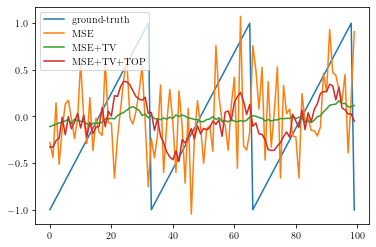

In [29]:
plt.figure()
plt.plot(betastar, label='ground-truth')
plt.plot(beta_std, label='MSE')
plt.plot(beta_stdtot, label='MSE+TV')
plt.plot(beta_stdtop, label='MSE+TV+TOP')
plt.legend(loc='upper left')
plt.show()

Using all penalties is the best: while mean square error (MSE) looks pretty random and total variation (TV) shrinks the coefficients too much,
    topology (TOP) achieves the best compromise. This can be further validated by computing the MSE on new test sets: in average, the MSE of the coefficients optimized with topology is lower than the others.

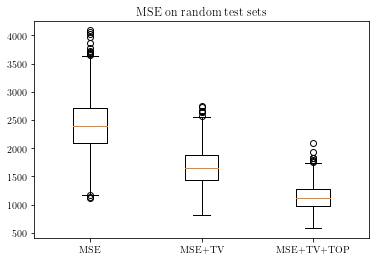

In [30]:
MSEstd, MSEtop, MSEtot = [], [], []
for s in range(1000):
    np.random.seed(s)
    Xnew = np.random.multivariate_normal(mean=np.zeros(shape=[p]), cov=np.eye(p), size=n)
    Ynew = np.matmul(Xnew, betastar)
    mse_std = np.square(np.matmul(Xnew, beta_std) - Ynew).sum()
    mse_tot = np.square(np.matmul(Xnew, beta_stdtot) - Ynew).sum()
    mse_top = np.square(np.matmul(Xnew, beta_stdtop) - Ynew).sum()
    MSEstd.append(mse_std)
    MSEtot.append(mse_tot)
    MSEtop.append(mse_top)
    
plt.figure()
plt.boxplot([MSEstd, MSEtot, MSEtop], labels=['MSE', 'MSE+TV', 'MSE+TV+TOP'])
plt.title('MSE on random test sets')
plt.show()

Finally, we can have again a look at the convergence and iterates.

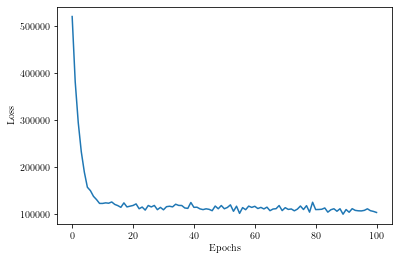

In [31]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

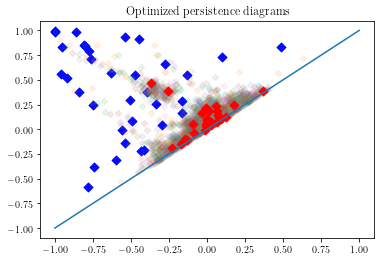

In [32]:
plt.figure()
plt.scatter(dgms[0][:,0], dgms[0][:,1], s=40, marker='D', c='blue')
for dg in dgms[:-1]:
    plt.scatter(dg[:,0], dg[:,1], s=20, marker='D', alpha=.1)
plt.scatter(dgms[-1][:,0], dgms[-1][:,1], s=40, marker='D', c='red')
plt.plot([-1,1], [-1,1])
plt.title('Optimized persistence diagrams')
plt.show()